In [2]:

import pandas as pd
import numpy as np


In [3]:
df_PE_Sales = pd.read_csv('./../raw_data/Excel_files/Top5k_Sales_PE_new_model_20210607_pre_campaign.csv', index_col=0)


In [4]:
###INTRODUCING THE REST
print(df_PE_Sales.head(20))
print(df_PE_Sales.dtypes)

            Sales_PE  Sales_PE_err  del_week  del_week_err  intercept  \
1000021922   -2.7164        0.2643   -0.0611        0.0123    13.5324   
1000080319   -2.0123        0.5307   -0.0389        0.0125    12.2816   
1000005727   -5.7830        0.9409   -0.0610        0.0520    29.7002   
1000007327   -2.9895        0.5150   -0.0096        0.0173    16.2228   
1000016194   -3.6670        0.4812   -0.0314        0.0125    19.4484   
1000048008   -1.2746        0.2520   -0.0204        0.0068     6.1285   
1000116614   -4.0372        0.5501   -0.0601        0.0178    28.5740   
1000123776   -4.4525        1.2165   -0.0663        0.0834    20.8146   
1000175476   -3.4585        0.4831   -0.1496        0.1339    15.8979   
1000176734   -1.9881        0.5152   -0.0021        0.0239    10.7002   
1000008470   -7.7407        1.2494   -0.0820        0.0545    36.8637   
1000124600   -2.9983        0.4939   -0.0315        0.0144    19.5207   
1000159178   -1.4844        0.3631   -0.0099       

In [5]:
df_filt = pd.read_csv('./../raw_data/Excel_files/Top5k_PE_filtered_20210607_pre_campaign.csv', index_col=0)

In [6]:
#PREPARE THE CONVERSION RATE FILE
#final_items = list(df_result_true.index.values)
final_items = list(df_PE_Sales.index.values)
print(len(final_items))



2305


In [7]:
print(df_filt.head(10))

     min_date    max_date   item_code  item_price_x  delivery_weeks  \
0  2020-01-01  2020-03-13  1000021922        129.99               2   
1  2020-04-15  2020-04-21  1000021922        119.99               4   
2  2020-04-23  2020-06-07  1000021922        129.99               2   
3  2020-06-11  2020-07-25  1000021922        129.99               2   
4  2020-07-31  2020-08-10  1000021922        119.99               2   
5  2020-08-11  2020-08-18  1000021922        129.99               2   
6  2020-08-19  2020-08-25  1000021922        129.99               3   
7  2020-08-26  2020-09-17  1000021922        129.99               2   
8  2020-10-03  2020-10-13  1000021922        114.99               2   
9  2020-11-29  2020-12-06  1000021922        114.99              15   

   avg_sales  avg_unique_views  avg_sessions  avg_marketing_cost_spend  \
0   1.589041        147.191781  1.607617e+08             204747.147616   
1   1.571429         79.428571  1.645571e+08             164942.044505

In [8]:
df_final = df_filt[df_filt['item_code'].isin(final_items)]

In [9]:
print(df_final.head())

     min_date    max_date   item_code  item_price_x  delivery_weeks  \
0  2020-01-01  2020-03-13  1000021922        129.99               2   
1  2020-04-15  2020-04-21  1000021922        119.99               4   
2  2020-04-23  2020-06-07  1000021922        129.99               2   
3  2020-06-11  2020-07-25  1000021922        129.99               2   
4  2020-07-31  2020-08-10  1000021922        119.99               2   

   avg_sales  avg_unique_views  avg_sessions  avg_marketing_cost_spend  \
0   1.589041        147.191781  1.607617e+08             204747.147616   
1   1.571429         79.428571  1.645571e+08             164942.044505   
2   2.086957         89.173913  1.495730e+08             124168.262194   
3   1.311111         74.022222  1.187547e+08             101518.823123   
4   1.636364         82.000000  1.126150e+08             125065.144351   

   conv_rate  ...  item_sub_category_1       item_sub_category_2 log_price  \
0   0.010797  ...          BADSCHRÄNKE  WASCHBECKE

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').config('spark.driver.memory', '8g').appName(
    'Sales_Margin_also').getOrCreate()


In [11]:
df_to_spark = df_final.groupby(['item_code']).nth(-1)
df_to_spark.reset_index(level=0, inplace=True)
df_to_spark.rename(columns={'index': 'item_code'}, inplace=True)


In [12]:
df_to_spark = df_to_spark[[
    'item_code',
    'min_date',
    'max_date',
    'item_price_x',
    'delivery_weeks',
    'avg_sales',
    'avg_unique_views',
    'avg_sessions',
    'avg_marketing_cost_spend',
    'conv_rate',
    'bin',
    'log_price',
    'log_delivery_weeks',
    'log_sales',
    'log_avg_unique_views',
    'log_conv_rate',
    'log_avg_sessions',
    'log_avg_marketing_cost_spend']]

In [13]:
df_to_spark.dtypes


item_code                         int64
min_date                         object
max_date                         object
item_price_x                    float64
delivery_weeks                    int64
avg_sales                       float64
avg_unique_views                float64
avg_sessions                    float64
avg_marketing_cost_spend        float64
conv_rate                       float64
bin                               int64
log_price                       float64
log_delivery_weeks              float64
log_sales                       float64
log_avg_unique_views            float64
log_conv_rate                   float64
log_avg_sessions                float64
log_avg_marketing_cost_spend    float64
dtype: object

In [14]:
df_final = df_final[[
    'item_code',
    'min_date',
    'max_date',
    'item_price_x',
    'delivery_weeks',
    'avg_sales',
    'avg_unique_views',
    'avg_sessions',
    'avg_marketing_cost_spend',
    'conv_rate',
    'bin',
    'log_price',
    'log_delivery_weeks',
    'log_sales',
    'log_avg_unique_views',
    'log_conv_rate',
    'log_avg_sessions',
    'log_avg_marketing_cost_spend']]
spark_df = spark.createDataFrame(df_final)

In [15]:
spark_df.createOrReplaceTempView('Final_table')


In [16]:
spark_last_price = spark.sql("""with max_price as (SELECT item_code, ROW_NUMBER() over (PARTITION BY item_code ORDER BY max_date DESC) as rn,
                                                    item_price_x, max_date, delivery_weeks
                                                    from final_table)
                                SELECT item_code, item_price_x, max_date, delivery_weeks
                                from max_price
                                where rn=1
                            """)
spark_last_price.show()

+----------+------------+----------+--------------+
| item_code|item_price_x|  max_date|delivery_weeks|
+----------+------------+----------+--------------+
|1000016121|      299.99|2021-04-28|             1|
|1000021904|      239.99|2021-04-23|             3|
|1000054054|      329.99|2021-04-26|            16|
|1000064483|       53.99|2021-03-07|             1|
|1000137922|      629.99|2021-04-28|             3|
|1000208251|      419.99|2021-02-26|             3|
|1000211528|       94.99|2021-04-28|             1|
|1000007431|      104.99|2021-04-28|             1|
|1000008030|      269.99|2021-04-15|             2|
|1000021988|       66.99|2021-03-15|             1|
|1000048003|      349.99|2021-04-23|             3|
|1000080285|      139.99|2021-04-15|             2|
|1000087583|      219.99|2021-03-28|             9|
|1000101087|      264.99|2021-04-15|             2|
|1000101103|      249.99|2021-04-02|             3|
|1000104169|      119.99|2021-04-28|             1|
|1000121623|

In [17]:
spark_last_price.createOrReplaceTempView('last_price')


In [18]:
df_PE_Sales.dtypes

Sales_PE         float64
Sales_PE_err     float64
del_week         float64
del_week_err     float64
intercept        float64
intercept_err    float64
dtype: object

In [19]:

#df_result_true.reset_index(level=0,inplace=True)
df_PE_Sales.reset_index(level=0, inplace=True)



In [20]:
df_PE_Sales.rename(columns={'index': 'item_code'}, inplace=True)

In [21]:
print(df_PE_Sales.head())

    item_code  Sales_PE  Sales_PE_err  del_week  del_week_err  intercept  \
0  1000021922   -2.7164        0.2643   -0.0611        0.0123    13.5324   
1  1000080319   -2.0123        0.5307   -0.0389        0.0125    12.2816   
2  1000005727   -5.7830        0.9409   -0.0610        0.0520    29.7002   
3  1000007327   -2.9895        0.5150   -0.0096        0.0173    16.2228   
4  1000016194   -3.6670        0.4812   -0.0314        0.0125    19.4484   

   intercept_err  
0         1.2491  
1         3.1825  
2         4.3197  
3         2.7397  
4         2.4576  


In [22]:
spark_PE_df = spark.createDataFrame(df_PE_Sales)

In [23]:
spark_PE_df.show()

+----------+-------------------+------------+--------------------+--------------------+---------+------------------+
| item_code|           Sales_PE|Sales_PE_err|            del_week|        del_week_err|intercept|     intercept_err|
+----------+-------------------+------------+--------------------+--------------------+---------+------------------+
|1000021922|            -2.7164|      0.2643|             -0.0611|              0.0123|  13.5324|            1.2491|
|1000080319|            -2.0123|      0.5307|             -0.0389|              0.0125|  12.2816|            3.1825|
|1000005727|-5.7829999999999995|      0.9409|              -0.061|0.052000000000000005|  29.7002|            4.3197|
|1000007327|            -2.9895|       0.515|             -0.0096|              0.0173|  16.2228|            2.7397|
|1000016194|             -3.667|      0.4812|             -0.0314|              0.0125|  19.4484|            2.4576|
|1000048008|            -1.2746|       0.252|             -0.020

In [24]:
spark_PE_df.createOrReplaceTempView('final_PE')

In [25]:
spark_final = spark.sql("""SELECT ftf.*,
                            fpe.sales_pe,
                            fpe.sales_pe_err,
                            fpe.del_week as beta_del_week,
                            fpe.del_week_err as beta_del_week_err,
                            fpe.intercept,
                            fpe.intercept_err
                            from last_price as ftf
                            INNER JOIN final_pe as fpe on fpe.item_code = ftf.item_code""")
spark_final.show()
spark_final.createOrReplaceTempView('spark_final_tmp')

+----------+------------+----------+--------------+--------+-------------------+--------------------+--------------------+-------------------+-------------+
| item_code|item_price_x|  max_date|delivery_weeks|sales_pe|       sales_pe_err|       beta_del_week|   beta_del_week_err|          intercept|intercept_err|
+----------+------------+----------+--------------+--------+-------------------+--------------------+--------------------+-------------------+-------------+
|1000016121|      299.99|2021-04-28|             1| -1.5734|             0.3957|             -0.0107|0.013000000000000001|             9.6288|        2.286|
|1000021904|      239.99|2021-04-23|             3| -3.8838|             0.8329|             -0.0205|              0.0227|            22.0802|       4.5178|
|1000054054|      329.99|2021-04-26|            16| -0.8534|             0.1496|             -0.0117|              0.0032|             5.0027|         0.79|
|1000064483|       53.99|2021-03-07|             1| -2.808

In [26]:
#spark.sql("""SELECT COUNT(DISTINCT item_code)
#from spark_final_tmp""").show()



In [29]:
#Introduce d_item table
sp_df_item = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/d_item/*.parquet',
    header=True)
sp_df_item.show()

+---------------+------------------+---------------------+-------------+----------------+----------+-------------+-----------+----------+-----------+--------------+-------------+--------------------+----------------------+--------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+---------+--------------------------------+---------------------------------------------+-----------------------+---------------------+------------------------+--------------------------+------------------------+--------------------+-----------+-------------------+------------------+-------------------+----------------------------+---------------+-----------------------+-----------------------+----------------------+------------------------------------+-------------------------------------------+-------------------------------------------------+--------------------------------------------------------+------------------------+------

In [30]:
#Introduce PC2 table
sp_df_pc2 = spark.read.parquet(
    '/Users/gabriele.sabato/PycharmProjects/raw_data/redshift_tables/f_item_status_last/*.parquet',
    header=True)
sp_df_pc2.show()

+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
|  item_skey|shop_skey|item_status_skey|item_status_weekly_skey|item_pc1_costs_before_cogs|item_pc2_costs_before_cogs|group_pc2_margin_simulated|group_pc2_margin_ratio_simulated|group_pc2_margin_simulated_pocket|group_pc2_margin_ratio_simulated_pocket|
+-----------+---------+----------------+-----------------------+--------------------------+--------------------------+--------------------------+--------------------------------+---------------------------------+---------------------------------------+
| 9022444508|        1|               1|                      1|                      null|                      null|                      null|                            null|                             null|                             

In [37]:
sp_df_item.createOrReplaceTempView('d_item_tmp')
sp_df_pc2.createOrReplaceTempView('d_item_pc2')

In [38]:
pc2_table = spark.sql(""" WITH pc2_avg as (
                            SELECT item_skey,
                            item_pc2_costs_before_cogs as pc2
                            from d_item_pc2
                            where shop_skey = 1 and item_pc2_costs_before_cogs IS NOT NULL)
                            SELECT pc.item_skey,di.item_code, pc.pc2
                            from d_item_tmp as di
                            INNER JOIN pc2_avg as pc on pc.item_skey = di.item_skey
                            where di.item_code like '0%'
                            """)
pc2_table.show()

+------------+------------------+-------+
|   item_skey|         item_code|    pc2|
+------------+------------------+-------+
| 52611470619|000000001000134743| 20.010|
| 84385921703|000000001000071807|156.289|
| 86157195106|000000001000244511| 13.960|
|155168951323|000000001000168394| 93.569|
|160741357340|000000001000209207|159.479|
|192734622947|000000001000094810|355.430|
|205869855153|000000001000085488|248.090|
|224112330866|000000001000174074| 18.070|
|232914582312|000000001000219189| 17.859|
|250762505087|000000001000066133|  8.210|
|254111485931|000000001000179190|321.079|
|263925540263|000000001000116596| 60.799|
|295387713504|000000001000248814|761.179|
|296512802915|000000001000156944| 19.090|
|310102063324|000000001000136606| 56.909|
|318946574713|000000001000039659|205.020|
|350221455850|000000001000033289| 29.219|
|365206948338|000000001000112137| 50.729|
|374059249977|000000001000177970| 58.630|
|475846433003|000000001000050340| 25.399|
+------------+------------------+-

In [39]:
pc2_table.createOrReplaceTempView('pc2_table')

In [40]:
spark.sql("""SELECT COUNT(item_code) FROM pc2_table""").show()
#spark.sql("""SELECT COUNT(item_skey) FROM pc2_table""").show()

+----------------+
|count(item_code)|
+----------------+
|          246731|
+----------------+



In [42]:
spark_pc2_final = spark.sql(""" SELECT sp.*, pc.pc2, pc.item_skey
                                from spark_final_tmp as sp
                                 INNER JOIN pc2_table as pc on sp.item_code = pc.item_code
                                 """)

spark_pc2_final.show()

+----------+------------+----------+--------------+--------+-------------------+--------------------+--------------------+-------------------+-------------+-------+---------------+
| item_code|item_price_x|  max_date|delivery_weeks|sales_pe|       sales_pe_err|       beta_del_week|   beta_del_week_err|          intercept|intercept_err|    pc2|      item_skey|
+----------+------------+----------+--------------+--------+-------------------+--------------------+--------------------+-------------------+-------------+-------+---------------+
|1000016121|      299.99|2021-04-28|             1| -1.5734|             0.3957|             -0.0107|0.013000000000000001|             9.6288|        2.286|130.330| 40600078796222|
|1000021904|      239.99|2021-04-23|             3| -3.8838|             0.8329|             -0.0205|              0.0227|            22.0802|       4.5178|123.280|138251605120553|
|1000054054|      329.99|2021-04-26|            16| -0.8534|             0.1496|             -0

In [43]:
df_final_spark = spark_pc2_final.toPandas()

In [44]:
df_final_spark = df_final_spark.astype({'pc2': 'float64'})

In [45]:
df_final_spark.to_csv('./pickle_files/df_Sales_PE_ready_for_Margin_20210607.csv')

In [46]:

#After_VAT = 0.81
import math

In [47]:
df_final_spark.dtypes

item_code              int64
item_price_x         float64
max_date              object
delivery_weeks         int64
sales_pe             float64
sales_pe_err         float64
beta_del_week        float64
beta_del_week_err    float64
intercept            float64
intercept_err        float64
pc2                  float64
item_skey              int64
dtype: object

In [48]:
df_final_spark.head()

,item_code,item_price_x,max_date,delivery_weeks,sales_pe,sales_pe_err,beta_del_week,beta_del_week_err,intercept,intercept_err,pc2,item_skey
0,1000016121,299.99,2021-04-28,1,-1.5734,0.3957,-0.0107,0.0130,9.6288,2.2860,130.33,40600078796222
1,1000021904,239.99,2021-04-23,3,-3.8838,0.8329,-0.0205,0.0227,22.0802,4.5178,123.28,138251605120553
2,1000054054,329.99,2021-04-26,16,-0.8534,0.1496,-0.0117,0.0032,5.0027,0.7900,177.05,258578614695714
3,1000064483,53.99,2021-03-07,1,-2.8085,0.6689,-0.0159,0.0247,16.9157,3.9106,30.64,277856157534661
4,1000137922,629.99,2021-04-28,3,-1.9520,0.6018,-0.0730,0.0314,12.0455,3.5729,369.85,256364191196067


(array([  2.,   0.,   0.,   2.,   1.,   3.,   4.,   6.,  13.,  14.,  23.,
         31.,  52.,  61., 121., 293., 635., 946.,  86.,   4.,   1.,   4.,
          1.,   0.,   1.]),
 array([-25.2784 , -23.91928, -22.56016, -21.20104, -19.84192, -18.4828 ,
        -17.12368, -15.76456, -14.40544, -13.04632, -11.6872 , -10.32808,
         -8.96896,  -7.60984,  -6.25072,  -4.8916 ,  -3.53248,  -2.17336,
         -0.81424,   0.54488,   1.904  ,   3.26312,   4.62224,   5.98136,
          7.34048,   8.6996 ]),
 <BarContainer object of 25 artists>)

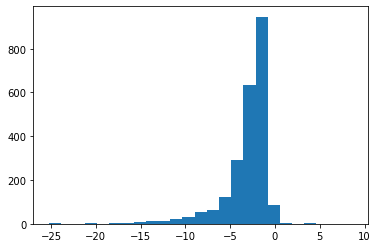

In [49]:
import matplotlib.pyplot as plt

plt.hist(df_final_spark['sales_pe'], bins=25)

(array([  1.,   0.,   0.,   1.,   2.,   6.,   0., 118., 917., 626., 297.,
        129.,  72.,  44.,  25.,  28.,  11.,   9.,   6.,   6.,   3.,   0.,
          1.,   0.,   2.]),
 array([-51.6542  , -44.493124, -37.332048, -30.170972, -23.009896,
        -15.84882 ,  -8.687744,  -1.526668,   5.634408,  12.795484,
         19.95656 ,  27.117636,  34.278712,  41.439788,  48.600864,
         55.76194 ,  62.923016,  70.084092,  77.245168,  84.406244,
         91.56732 ,  98.728396, 105.889472, 113.050548, 120.211624,
        127.3727  ]),
 <BarContainer object of 25 artists>)

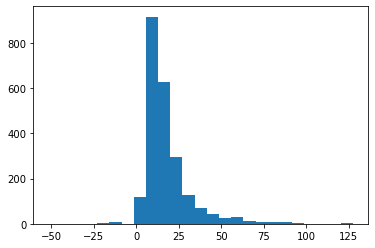

In [50]:
plt.hist(df_final_spark['intercept'], bins=25)

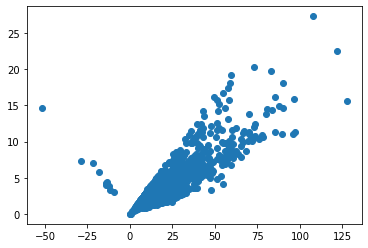

In [51]:
plt.scatter(df_final_spark['intercept'], df_final_spark['intercept_err'])

In [52]:
df_intercept_filter = df_final_spark.copy()
df_intercept_filter['intercept_rel_err'] = np.fabs(df_final_spark['intercept_err'] / df_final_spark['intercept'])
df_intercept_filter['beta_del_week_rel_err'] = np.fabs(
    df_final_spark['beta_del_week_err'] / df_final_spark['beta_del_week'])

In [53]:
#df_intercept_filter['intercept_rel_err'].nlargest()
df_intercept_filter = df_intercept_filter[3 * df_intercept_filter['intercept_rel_err'] < 1]
df_intercept_filter['intercept_rel_err'].nlargest()

984     0.329848
881     0.329776
2077    0.329402
1999    0.328433
776     0.328301
Name: intercept_rel_err, dtype: float64

In [54]:
df_intercept_filter['beta_del_week_rel_err'].nlargest()
df_del_week_filter = df_intercept_filter[3 * df_intercept_filter['beta_del_week_rel_err'] < 1]
df_del_week_filter['intercept_rel_err'].nlargest()

1680    0.324060
2236    0.321744
1318    0.317442
983     0.315509
127     0.310579
Name: intercept_rel_err, dtype: float64

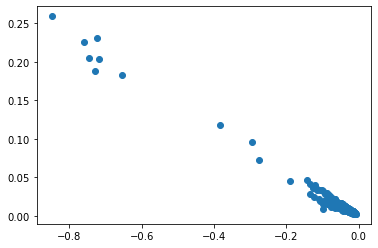

In [55]:
plt.scatter(df_del_week_filter['beta_del_week'], df_del_week_filter['beta_del_week_err'])

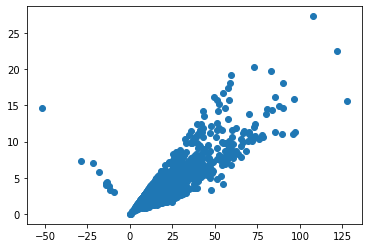

In [56]:
plt.scatter(df_intercept_filter['intercept'], df_intercept_filter['intercept_err'])

In [57]:
####### MARGIN #########
def calculate_Margin(dataf=df_final_spark, increment=0.01, direction='up', prev_inc = 0.0):
    if direction == 'down':
        increment *= -1
        prev_inc  *= -1

    VAT = 1.19

    N = int(increment/0.01)
    M = int(prev_inc/0.01)
    N_minus_M = N - M
    #print('N = ', N, 'M = ', M, 'N - M = ', N_minus_M)
    if np.fabs(increment) == 0.01:
        dataf['x'] = dataf['item_price_x']
        dataf['Delta_x'] = dataf['item_price_x'] * 0.01

    dataf['Delta_cost'] = ((dataf['x'] + M * dataf['Delta_x'])/VAT - dataf['pc2']) #change! x + 1dx

    dataf['Delta_N_Sales'] = N_minus_M * (dataf['Delta_x'] / (dataf['x'] + M * dataf['Delta_x'])) * dataf['sales_pe']
    dataf['log_x_prime'] = np.log(dataf['x'] + N*dataf['Delta_x'])
    dataf['N_prime_sales'] = dataf['sales_pe'] * dataf['log_x_prime'] + (
            dataf['beta_del_week'] * dataf['delivery_weeks']) + dataf['intercept']
    dataf['Delta_Margin'] = dataf['Delta_N_Sales'] * dataf['Delta_cost'] + dataf['N_prime_sales'] * N_minus_M * dataf['Delta_x']
    #dataf['N_prime_sales_err'] = np.sqrt(np.power(dataf['log_x_prime'] * dataf['sales_pe_err'], 2) + np.power(
    #    dataf['beta_del_week_err'] * dataf['delivery_weeks'], 2) + np.power(dataf['intercept_err'], 2))
    #dataf['Delta_Margin_err'] = np.sqrt(
    #    np.power(dataf['sales_pe_err'] * dataf['Delta_cost'] * dataf['Delta_x'] / dataf['x'], 2) + np.power(
    #        dataf['N_prime_sales_err'] * dataf['Delta_x'], 2))

    #dataf['N_prime_sales_err_no_intercept_err'] = np.sqrt(
    #    np.power(dataf['log_x_prime'] * dataf['sales_pe_err'], 2) + np.power(
    #        dataf['beta_del_week_err'] * dataf['delivery_weeks'], 2))
    #dataf['Delta_Margin_err_no_intercept'] = np.sqrt(
    ##    np.power(dataf['sales_pe_err'] * dataf['Delta_cost'] * dataf['Delta_x'] / dataf['x'], 2) + np.power(
    #        dataf['N_prime_sales_err_no_intercept_err'] * dataf['Delta_x'], 2))
    #dataf['N_prime_sales_err_no_del_week'] = np.sqrt(
    #    np.power(dataf['log_x_prime'] * dataf['sales_pe_err'], 2) + + np.power(dataf['intercept_err'], 2))
    #dataf['Delta_Margin_err_no_del_week'] = np.sqrt(
    #    np.power(dataf['sales_pe_err'] * dataf['Delta_cost'] * dataf['Delta_x'] / dataf['x'], 2) + np.power(
    #        dataf['N_prime_sales_err_no_del_week'] * dataf['Delta_x'], 2))

In [58]:
def classify(dataf=df_final_spark, flag='up'):
    direction = ['up', 'down']
    if flag == 'down':
        direction = direction[::-1]
    dataf['Group_flag'] = np.where(3 * dataf['Delta_Margin_err'] - np.fabs(dataf['Delta_Margin']) > 0, 'neutral',
                                   np.where(
                                       dataf['Delta_Margin'] > 0, direction[0],
                                       direction[1]))



In [59]:
def classify_no_err(dataf=df_final_spark, flag='up'):
    direction = ['up', 'down']
    if flag == 'down':
        direction = direction[::-1]

    dataf['Group_flag'] = np.where(dataf['Delta_Margin'] > 0, direction[0], 'not_defined')


In [60]:
original_df = df_final_spark.copy()
print(len(original_df.index))
tmp_df = pd.DataFrame()
original_df_up = pd.DataFrame()
original_df_down = pd.DataFrame()

2304


In [61]:
list_of_columns = [
    'item_code',
    'item_price_x',
    'x',
    'delivery_weeks',
    'sales_pe',
    'sales_pe_err',
    'beta_del_week',
    'beta_del_week_err',
    'intercept',
    'intercept_err',
    'Delta_x',
    'Delta_Margin']
increments_list = [0.01, 0.05, 0.1, 0.13, 0.14]

for index, inc in enumerate(increments_list):
    print('Increment = ' + str(inc))

    if inc == 0.01:
        original_tmp = original_df.copy()  #create tmp df
        calculate_Margin(original_df, inc, 'up')  #calculate Margin up
        classify_no_err(original_df, 'up')  #classify the new dataframe
        original_df_up = original_df_up.append(original_df[original_df['Group_flag'] == 'up'])
        #print(original_df.dtypes)
        #print(original_tmp.dtypes)
        #tmp_df = tmp_df.append(original_df[original_df['Group_flag'] == 'not_defined'])

        calculate_Margin(original_tmp, inc, 'down')
        classify_no_err(original_tmp, 'down')
        original_df_down = original_df_down.append(original_tmp[original_tmp['Group_flag'] == 'down'])
        #tmp_df = tmp_df.append(original_tmp[original_tmp['Group_flag'] == 'not_defined'])
        #print('up\n', original_df_up[list_of_columns].head())
        #print('down\n', original_df_down[list_of_columns].head())
        #print('tmp_df\n', tmp_df.head())
        #print('Total items\n', len(tmp_df.index) +len(original_df_up.index) + len(original_df_down.index))
    if inc > 0.01:
        #increment_price(original_df_up)
        calculate_Margin(original_df_up, inc, 'up', increments_list[index-1])
        classify_no_err(original_df_up, 'up')
        #tmp_df = tmp_df.append(original_df_up[original_df_up['Group_flag'] == 'not_defined'])
        original_df_up = original_df_up[original_df_up['Group_flag'] == 'up']

        #increment_price(original_df_down)
        calculate_Margin(original_df_down, inc, 'down', increments_list[index-1])
        classify_no_err(original_df_down, 'down')
        #tmp_df = tmp_df.append(original_df_down[original_df_down['Group_flag'] == 'not_defined'])
        original_df_down = original_df_down[original_df_down['Group_flag'] == 'down']
        #print('up\n', original_df_up[list_of_columns].head())
        #print('down\n', original_df_down[list_of_columns].head())
        #print('tmp\n',tmp_df_neutral.head())
        #print('up\n', original_df_up.head())
        #print('down\n',original_df_down.head())

    #original_df_down['Margin_base'] = original_df_down['Margin_down']
    #original_df_up['Margin_base'] = original_df_up['Margin_up']
    original_df_up ['Increment'] = f'{inc*100.}%'
    original_df_down ['Increment'] = f'{-inc*100.}%'
    print(len(original_df_up.index))
    print(len(original_df_down.index))
    #print(original_df_up.head())


Increment = 0.01
913
1350
Increment = 0.05
840
1250
Increment = 0.1
727
1090
Increment = 0.13
645
937
Increment = 0.14
615
872


In [62]:
original_df_up.head()
original_df_down.head()

,item_code,item_price_x,max_date,delivery_weeks,sales_pe,sales_pe_err,beta_del_week,beta_del_week_err,intercept,intercept_err,...,item_skey,x,Delta_x,Delta_cost,Delta_N_Sales,log_x_prime,N_prime_sales,Delta_Margin,Group_flag,Increment
2,1000054054,329.99,2021-04-26,16,-0.8534,0.1496,-0.0117,0.0032,5.0027,0.7900,...,258578614695714,329.99,3.2999,64.203193,0.009809,5.648239,-0.004708,0.645316,down,-14.000000000000002%
4,1000137922,629.99,2021-04-28,3,-1.9520,0.6018,-0.0730,0.0314,12.0455,3.5729,...,256364191196067,629.99,6.2999,90.730924,0.022437,6.294881,-0.461108,4.940643,down,-14.000000000000002%
7,1000007431,104.99,2021-04-28,1,-18.2928,2.4617,-0.1186,0.1062,85.2384,11.3301,...,73591042629309,104.99,1.0499,33.767395,0.210262,4.503042,2.746549,4.216400,down,-14.000000000000002%
10,1000048003,349.99,2021-04-23,3,-2.7317,0.3851,-0.0089,0.0067,16.2329,2.1005,...,33009929417484,349.99,3.4999,87.475042,0.031399,5.707082,0.616165,0.590100,down,-14.000000000000002%
12,1000087583,219.99,2021-03-28,9,-1.5979,0.4264,-0.0370,0.0085,8.7587,2.1987,...,191583886188344,219.99,2.1999,46.613025,0.018367,5.242759,0.048295,0.749882,down,-14.000000000000002%


In [63]:
original_df_up.to_csv('../raw_data/Excel_files/Item_margin_up_pre_campaign_202106.csv')
original_df_down.to_csv('../raw_data/Excel_files/Item_margin_down_pre_campaign_202106.csv')


In [64]:
original_df_up.dtypes


item_code              int64
item_price_x         float64
max_date              object
delivery_weeks         int64
sales_pe             float64
sales_pe_err         float64
beta_del_week        float64
beta_del_week_err    float64
intercept            float64
intercept_err        float64
pc2                  float64
item_skey              int64
x                    float64
Delta_x              float64
Delta_cost           float64
Delta_N_Sales        float64
log_x_prime          float64
N_prime_sales        float64
Delta_Margin         float64
Group_flag            object
Increment             object
dtype: object

In [55]:
#original_tmp['DM_err_ratios'] = original_tmp['Delta_Margin_err'] / original_tmp['Delta_Margin_err_no_intercept']
#original_tmp['N_sales_err_ratios'] = original_tmp['N_prime_sales_err'] / original_tmp[
#    'N_prime_sales_err_no_intercept_err']
#original_tmp['DM_err_ratios_dw'] = original_tmp['Delta_Margin_err'] / original_tmp['Delta_Margin_err_no_del_week']
#original_tmp['N_sales_err_ratios_dw'] = original_tmp['N_prime_sales_err'] / original_tmp[
#    'N_prime_sales_err_no_del_week']
#print(original_tmp['DM_err_ratios'].mean(), original_tmp['N_sales_err_ratios'].mean())
#print(original_tmp['DM_err_ratios_dw'].mean(), original_tmp['N_sales_err_ratios_dw'].mean())



KeyError: 'Delta_Margin_err'